In [1]:
#for Data
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sys 
sys.path.append("../Function/")
from function import remove_high_corr
from function import remove_outliers

# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#for NN
import keras
from keras import models
from keras import layers
from keras.layers import Dropout
import tensorflow as tf


upload data

In [2]:
df = pd.read_excel("../../site_info_ver_4_lite.xlsx")

In [3]:
df.Site_Name.unique()[0]

'Eilat Coral Beach'

In [4]:
df1 = df[df.Site_Name== df.Site_Name.unique()[0]]
df1.drop("Site_Name",axis=1,inplace=True)
df1.dropna(inplace=True)
df1 = df1.sort_values(["Date"])
df1.reset_index(drop=True,inplace=True)
df1 = df1.set_index(["Date"],drop=True)
# df1.index.freq = "MS"

C:\Users\asars\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\asars\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Define X and y and scaled them

In [5]:
df1_scaled = df1
# df1_scaled = pd.get_dummies(df1_scaled,'Site_Name',drop_first=True)
cols_min_max_list = [x for x in df1_scaled.columns if x not in ['Israelis_Count','Tourists_Count','Total'] ]
targets_list = ['Israelis_Count','Tourists_Count','Total']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#scale columns
df1_scaled[cols_min_max_list] = scaler.fit_transform(df1_scaled[cols_min_max_list])

#scale Traget
df1_scaled[targets_list] = np.log(df1_scaled[targets_list]+0.01)
df1_scaled[targets_list]

X_scaled = df1_scaled.drop(targets_list,axis=1)
targets_scaled = df1_scaled[targets_list]



In [6]:
# df1_scaled.drop(remove_high_corr(df1_scaled.drop(['Tourists_Count','Total','Date_year','Date_month','Date_week','Date_day'],axis=1),'Israelis_Count',0.4),axis=1,inplace=True)

split the data

In [7]:
y=targets_scaled.Israelis_Count
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.3,shuffle=False,random_state=False)
train_df_scaled = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)

val_df_scaled = pd.merge(left=X_val, right=y_val, left_index=True, right_index=True)

In [8]:
# y=targets_scaled.Israelis_Count
# X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X_scaled, y, test_size=0.2,shuffle=False,random_state=False)
# train_df_scaled = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)

# X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5,shuffle=False,random_state=False)
# val_df_scaled = pd.merge(left=X_val, right=y_val, left_index=True, right_index=True)
# test_df_scaled = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)

In [9]:
from keras.preprocessing.sequence import TimeseriesGenerator
#define generator
n_input = 4
n_features = len(X_train.columns)
# generator = TimeseriesGenerator?
generator = TimeseriesGenerator(X_train,y_train, length=n_input ,batch_size=1)
# generator_val = TimeseriesGenerator(X_val,y_val, length=n_input ,batch_size=1)

creat model

In [10]:
from keras import backend
 
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
    # Create the Keras model.

model = models.Sequential()
model.add(layers.LSTM(len(X_train.columns),activation='relu',input_shape=(n_input,n_features),return_sequences = True))
model.add(Dropout(0.5))
model.add(layers.LSTM(124,activation='relu',return_sequences = True))
model.add(Dropout(0.3))
model.add(layers.LSTM(64,activation='relu',return_sequences = True))
model.add(Dropout(0.3))
model.add(layers.LSTM(124,activation='relu',return_sequences = False))
model.add(Dropout(0.3))



model.add(layers.Dense(1))
model.compile(optimizer='adam',loss=[rmse])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 81)             52812     
                                                                 
 dropout (Dropout)           (None, 4, 81)             0         
                                                                 
 lstm_1 (LSTM)               (None, 4, 124)            102176    
                                                                 
 dropout_1 (Dropout)         (None, 4, 124)            0         
                                                                 
 lstm_2 (LSTM)               (None, 4, 64)             48384     
                                                                 
 dropout_2 (Dropout)         (None, 4, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 124)               9

In [12]:
# model.fit?
# model.fit(generator,epochs=100,validation_data=generator_val)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
model.fit(x=generator,epochs=1000,callbacks=[callback])


Epoch 1/1000
587/587 [==============================] - 8s 8ms/step - loss: 1.3660
Epoch 2/1000
587/587 [==============================] - 5s 9ms/step - loss: 0.9121
Epoch 3/1000
587/587 [==============================] - 4s 7ms/step - loss: 0.8549
Epoch 4/1000
587/587 [==============================] - 5s 8ms/step - loss: 0.8048
Epoch 5/1000
587/587 [==============================] - 4s 7ms/step - loss: 0.8261
Epoch 6/1000
587/587 [==============================] - 4s 7ms/step - loss: 0.7591
Epoch 7/1000
587/587 [==============================] - 5s 9ms/step - loss: 0.7723
Epoch 8/1000
587/587 [==============================] - 5s 9ms/step - loss: 0.7647
Epoch 9/1000
587/587 [==============================] - 7s 11ms/step - loss: 0.7352
Epoch 10/1000
587/587 [==============================] - 8s 13ms/step - loss: 0.7596: 0s - loss: 0.760
Epoch 11/1000
587/587 [==============================] - 7s 12ms/step - loss: 0.7077
Epoch 12/1000
587/587 [==============================] - 7s 11ms

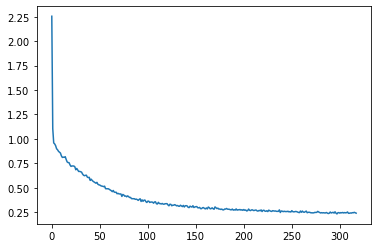

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
X,y=generator[0]
X.shape

(1, 4, 81)

In [ ]:
val_prediction = [] 
first_eval_batch = X_train[-n_input:]
current_batch = first_eval_batch.to_numpy().reshape((1,n_input,n_features))

for i in range(len(y_val)):
    current_pred = model.predict(current_batch)[0]
    val_prediction.append(current_pred)

    current_batch = current_batch[:,1:]
    current_batch = np.append(current_batch,[X_val[i:i+1].values],axis=1)


In [ ]:
np.array((np.exp(val_prediction)))

array([[[ 67.06746 ],
        [ 68.81996 ],
        [ 75.86368 ],
        [101.32618 ]],

       [[ 72.37737 ],
        [ 70.5729  ],
        [ 74.7287  ],
        [ 83.445786]],

       [[ 79.018074],
        [ 79.28238 ],
        [ 88.75497 ],
        [ 94.09656 ]],

       ...,

       [[467.09116 ],
        [542.5886  ],
        [540.79553 ],
        [557.53455 ]],

       [[273.58133 ],
        [302.90652 ],
        [361.1515  ],
        [379.37265 ]],

       [[598.7825  ],
        [635.0761  ],
        [647.40955 ],
        [663.4211  ]]], dtype=float32)

In [ ]:
val_df = pd.DataFrame(np.exp(val_df_scaled.Israelis_Count))
val_df['Preditiction'] =np.exp(val_prediction)
val_df.plot(kind='line',figsize=(14,5))
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(val_df['Israelis_Count'],val_df['Preditiction']))
print(rmse)

ValueError: Wrong number of dimensions. values.ndim > ndim [3 > 2]

In [ ]:
val_df

,Israelis_Count,Preditiction
Date,,
2019-12-20,159.01,126.324715
2019-12-23,214.01,75.170891
2019-12-24,433.01,117.743767
2019-12-25,628.01,103.065437
2019-12-26,327.01,182.065689
...,...,...
2021-08-01,731.01,278.452148
2021-08-02,1132.01,490.091400
2021-08-06,971.01,588.181519


In [ ]:
val_df['diff']=abs(val_df.Israelis_Count-val_df.Preditiction)
val_df.loc[val_df['diff'] < 100]

,Israelis_Count,Preditiction,diff
Date,,,
2019-12-20,159.01,126.324715,32.685285
2020-01-01,78.01,42.005531,36.004469
2020-01-02,44.01,24.108080,19.901920
2020-01-09,16.01,27.404430,11.394430
2020-01-10,22.01,114.081947,92.071947
...,...,...,...
2021-04-18,306.01,384.108795,78.098795
2021-04-25,401.01,336.071106,64.938894
2021-07-11,585.01,574.775330,10.234670
